# Inferring a binomial Probability via Exact Mathematical Analysis

In [1]:
from scipy.optimize import fmin
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Just makes everything nicer

%matplotlib inline
sns.set_style('darkgrid')

## Utility functions

In [2]:
def update_beta(a, b, N, z):
    '''Update beta prior with data'''
    return (z + a, N - z + b)  # See p. 132

def distribution_hdi(distribution, interval_mass=.95):
    '''
    Calculate the HDI of a given distribution.
    distribution : most have ppf method.
    Based on Kruschke R code and http://stackoverflow.com/a/25777507/1224456
    '''

    def interval_width(low_tail):
        low_tail_probability = distribution.ppf(low_tail)
        high_tail_probability = distribution.ppf(low_tail + interval_mass)
        return high_tail_probability - low_tail_probability

    # Find low_tail that minimizes interval_width
    best_low_tail = fmin(interval_width, 0, ftol=1e-8, disp=False)[0]
    # Return interval as array([low, high])
    return distribution.ppf([best_low_tail, best_low_tail+ interval_mass])

The following are marely ploting utils, for reducing code duplication.

In [3]:
def prior_posterior_plot(prior, posterior, text, hdi_tails=None):
    x = np.linspace(0, 1, 100)
    plt.text(.05, 2, text)
    plt.plot(x, prior.pdf(x), label='prior')
    plt.plot(x, posterior.pdf(x), label='posterior')

    # Posterior mean annotation
    mean = posterior.mean()
    mean_y = posterior.pdf(mean)
    plt.annotate('mean: {:.2f}'.format(mean), xy=(mean, mean_y),
                 horizontalalignment='center', xytext=(mean, .5 * mean_y),
                 arrowprops=dict(facecolor='black', width=.4, shrink=.05))

    if hdi_tails is not None:
        hdi_plot(posterior, hdi_tails)

    plt.gca().get_yaxis().set_visible(False)  # Disable y ticks


def hdi_plot(distribution, hdi_tails):
    for tail in hdi_tails:
        plt.text(tail, 0, '{:.3f}'.format(tail))
    x = np.linspace(*hdi_tails, num=100)
    plt.fill_between(x, 0, distribution.pdf(x), color='green', alpha=0.3)

# Exercise 1

Demonstrate how a single flip affect the prior.

Shows that the posterior is invariant under re-ordering of the data (the coin flips).

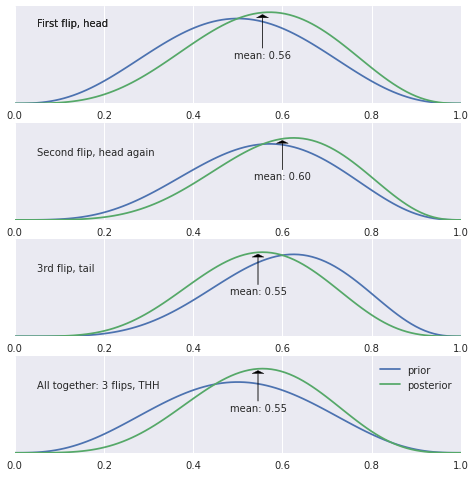

In [4]:
plt.figure(figsize=(8, 8))

# Question A
plt.subplot(4, 1, 1)
a, b = 4, 4
prior = beta(a, b)
plt.text(0.05, 2, 'First flip, head')
a, b = update_beta(a, b, N=1, z=1)
posterior = beta(a, b)
prior_posterior_plot(prior, posterior, 'First flip, head')

# Question B
plt.subplot(4, 1, 2)
prior = posterior
a, b = update_beta(a, b, N=1, z=1)
posterior = beta(a, b)
prior_posterior_plot(prior, posterior, 'Second flip, head again')

# Question C
plt.subplot(4, 1, 3)
prior = posterior
a, b = update_beta(a, b, N=1, z=0)
posterior = beta(a, b)
prior_posterior_plot(prior, posterior, '3rd flip, tail')

# Question D
plt.subplot(4, 1, 4)
a, b = 4, 4
prior = beta(a, b)
a, b = update_beta(a, b, N=3, z=2)
posterior = beta(a, b)
prior_posterior_plot(prior, posterior, 'All together: 3 flips, THH')

_ = plt.legend(loc='best')

# Exercise 2

HDI demonstration.

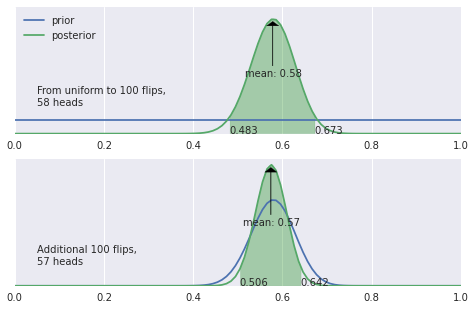

In [5]:
plt.figure(figsize=(8, 5))

# Question A
plt.subplot(2, 1, 1)
a, b = 1, 1
prior = beta(a, b)
a, b = update_beta(a, b, N=100, z=58)
posterior = beta(a, b)
text = 'From uniform to 100 flips,\n58 heads'
hdi_tails = distribution_hdi(posterior)
prior_posterior_plot(prior, posterior, text, hdi_tails=hdi_tails)
plt.legend(loc=2)

# Question B
plt.subplot(2, 1, 2)
prior = posterior
a, b = update_beta(a, b, N=100, z=57)
posterior = beta(a, b)
text = 'Additional 100 flips,\n57 heads'
hdi_tails = distribution_hdi(posterior)
prior_posterior_plot(prior, posterior, text, hdi_tails=hdi_tails)

# Exercise 3

Prob A: 40 choose F and 10 choose J

0.5 is outside of the HDI and therefor we will infer that participants biased toward F.

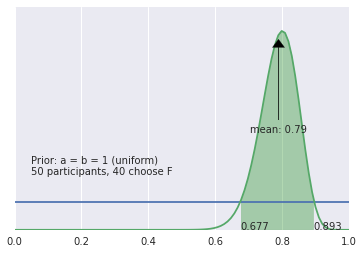

In [6]:
a = b = 1
prior = beta(a, b)
posterior = beta(*update_beta(a, b, 50, 40))
hdi_tails = distribution_hdi(posterior)
text = '''
Prior: a = b = 1 (uniform)
50 participants, 40 choose F
'''.strip()
prior_posterior_plot(prior, posterior, text, hdi_tails=hdi_tails)

Prob B: 15 choose F and 35 choose J

0.5 is outside of the HDI and therefor we will infer that participants biased toward J.

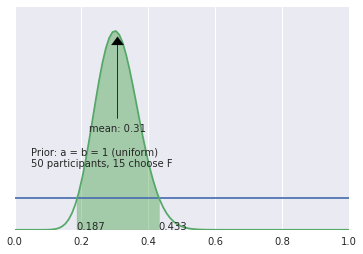

In [7]:
a = b = 1
prior = beta(a, b)
posterior = beta(*update_beta(a, b, 50, 15))
hdi_tails = distribution_hdi(posterior)
text = '''
Prior: a = b = 1 (uniform)
50 participants, 15 choose F
'''.strip()
prior_posterior_plot(prior, posterior, text, hdi_tails=hdi_tails)

# Exercise 4

Introspecting unusual, bimodal, prior, and its affect on the posterior.

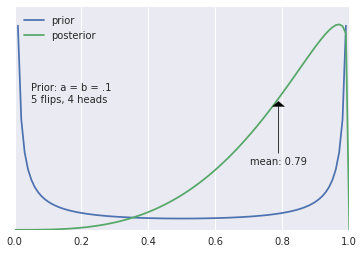

In [8]:
a = b = 0.1
prior = beta(a, b)
posterior = beta(*update_beta(a, b, N=5, z=4))
text = '''
Prior: a = b = .1
5 flips, 4 heads
'''.strip()
prior_posterior_plot(prior, posterior, text)
_ = plt.legend(loc='best')

# Exercise 5

Comparing the posterior we get with the same data and different priors.

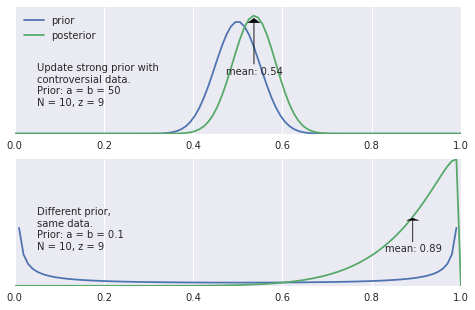

In [9]:
plt.figure(figsize=(8, 5))

# Question A
plt.subplot(2, 1, 1)
a = b = 50  # Strong prior belief that the coin is fair
prior = beta(a, b)
posterior = beta(*update_beta(a, b, N=10, z=9))
text = '''Update strong prior with\ncontroversial data.
Prior: a = b = {}
N = 10, z = 9
'''.format(a).strip()
prior_posterior_plot(prior, posterior, text)
plt.legend(loc=2)

# Question B
plt.subplot(2, 1, 2)
a = b = .1  # Strong prior belief that the coin is unfair
prior = beta(a, b)
posterior = beta(*update_beta(a, b, N=10, z=9))
text = '''Different prior,\nsame data.
Prior: a = b = {}
N = 10, z = 9
'''.format(a).strip()
prior_posterior_plot(prior, posterior, text)